# PS04#08 Famous kernels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Stationary covariance functions
Recall the definition of the SE kernel on $\mathbb{X}\subseteq\mathbb{R}^D$,
$$
k: \mathbb{X}\times\mathbb{X}\rightarrow\mathbb{R},
\quad 
k(x,x')=\sigma_\mathrm{f}\exp\left(-\frac{\|x-x'\|^2}{2\ell^2}\right),
$$
Looking closely, it turns out that this covariance function depends on its arguments $x,x'$ only through their difference $x-x'$. A covariance function of the form $k(x,x')=\Psi(x-x')$ is called _stationary_. The name comes from the fact that such a covariance function is translation-invariant: If both arguments are shifted by the same offset, the function value does not change. Intuitively, the covariance function behaves everywhere the same.

## Isotropic / radial covariance functions
**Additional Exercise** A translation is a function $T:\mathbb{R}^D \rightarrow \mathbb{R}^D$ of the form $T(x)=x+b$ for some $b \in \mathbb{R}^D$. Let $k: \mathbb{R}^D\times\mathbb{R}^D\rightarrow\mathbb{R}$ be any stationary covariance function, i.e., $k(x,x')=\Psi(x-x')$ for some $\Psi:\mathbb{R}^D\rightarrow\mathbb{R}$. Show that for any translation $T$ and all $x,x'\in\mathbb{R}^D$ we have $k(T(x),T(x'))=k(x,x')$.

Returning to the SE covariance function, we observe that actually it does only depend on the norm of the difference of its arguments $x,x'$, i.e., only $\|x-x'\|$ is used in the covariance function. In general, a covariance function $k(x,x')=\Psi(\|x-x'\|)$ is called _isotropic_ or _radial_ and $\Psi$ is then sometimes called a _radial basis function_ (RBF).

**Additional Exercise** Here is an explanation for the latter terminology. Let $k: \mathbb{R}^D\times\mathbb{R}^D\rightarrow\mathbb{R}$ be any radial covariance function, i.e., $k(x,x')=\Psi(\|x-x'\|)$ for some $\Psi:\mathbb{R}^D\rightarrow\mathbb{R}$. Show that for all orthogonal $A\in\mathbb{R}^D$ (this means that $A^\top A = I$) and $x,x\in\mathbb{R}^D$ we have $k(Ax,Ax')=k(x,x')$.

Since rotation matrices (encoding rotation around the origin) are orthogonal matrices, this shows that radial covariance functions are invariant to rotations. This means that their level sets are circles, giving one explanation for the term radial.

We now present some important isotropic covariance functions of the form $k(x,x')=\Psi(\|x-x'\|)$.

### The Squared Exponential (SE) or Gaussian covariance function
The SE covariance function is given by
$$
\Psi_\mathrm{SE}(r) = \sigma_\mathrm{f} \exp\left(-\frac{r^2}{2\ell^2} \right)
$$
where $\sigma_\mathrm{f}>0$ is the signal variance and $\ell>0$ the length scale.

**Question** Implement $\Psi_\mathrm{SE}$ as a numpy function and plot $k_\mathrm{SE}(\cdot,x)$ ($D=1$) for different $\sigma_\mathrm{f}$ and $\ell$. Does it matter which $x$ is chosen? How do the two hyperparameter influence the shape of the function? What does the shape of the function mean for the covariances of a GP?

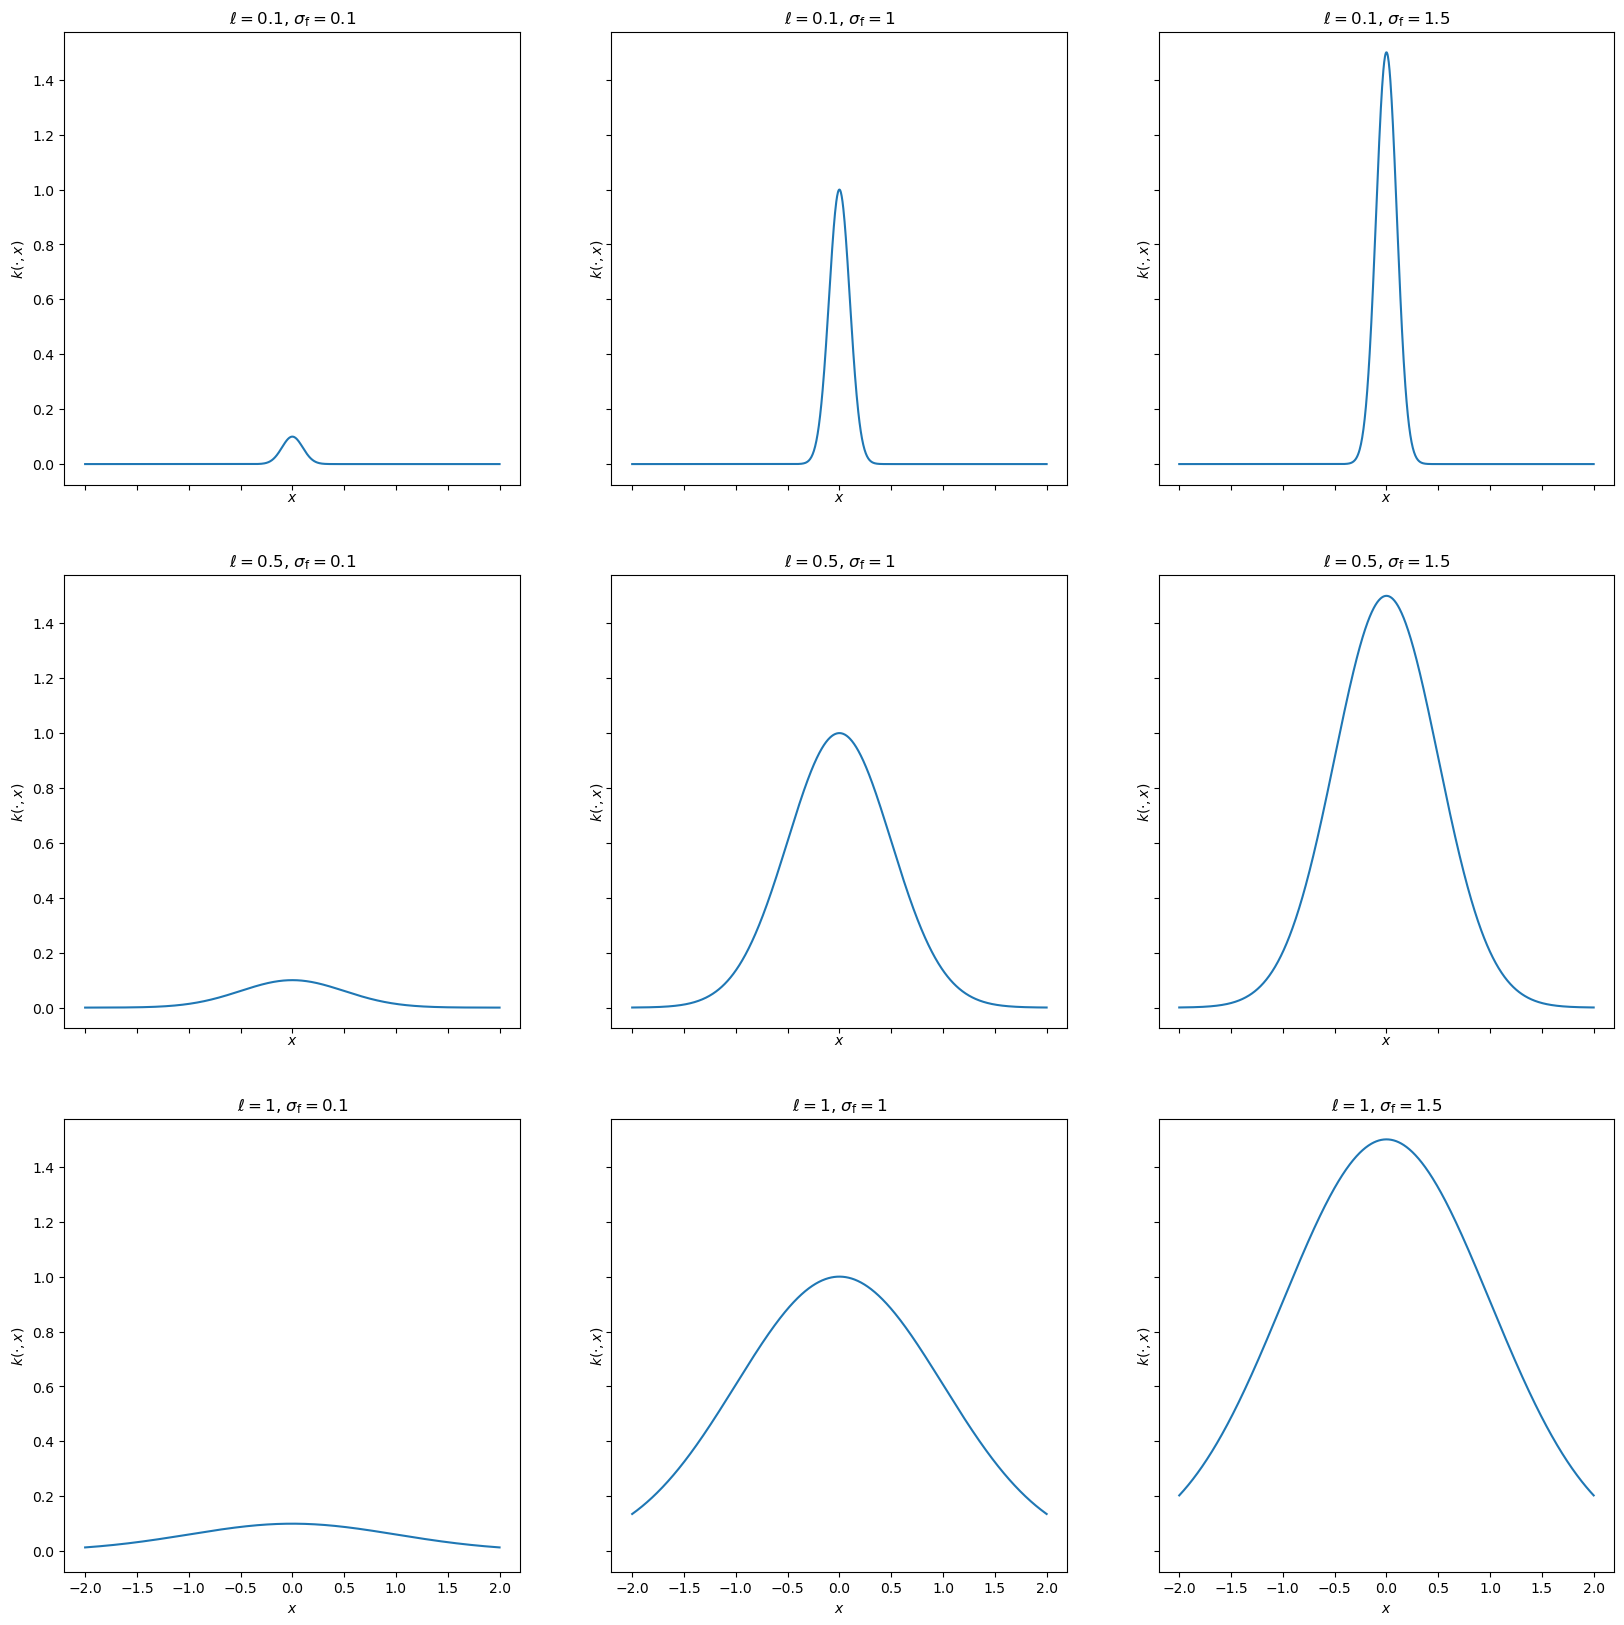

In [3]:
### BEGIN SOLUTION
def psi_se(r, ell=1, sigma_f=1):
    return sigma_f*np.exp(-r**2/(2*ell**2))

# Hyperparameters
ells = [0.1, 0.5, 1]
sigmas = [0.1, 1, 1.5]

# Plotting grid
xs = np.linspace(-2,2,1000)

# Since the covariance function is translation invariant, the choice of x does not matter and we set x=0
fig, axs = plt.subplots(3,3, figsize=(20,20), sharex=True, sharey=True)
for i_ell, ell in enumerate(ells):
    for i_sigma, sigma_f in enumerate(sigmas):
        ys = psi_se(xs, ell=ell, sigma_f=sigma_f)
        ax = axs[i_ell,i_sigma]
        ax.plot(xs, ys)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$k(\cdot,x)$')
        ax.set_title(f'$\ell={ell}$, $\sigma_\mathrm{{f}}={sigma_f}$')
        
### END SOLUTION

**Question** Repeat this, but now in 2D.

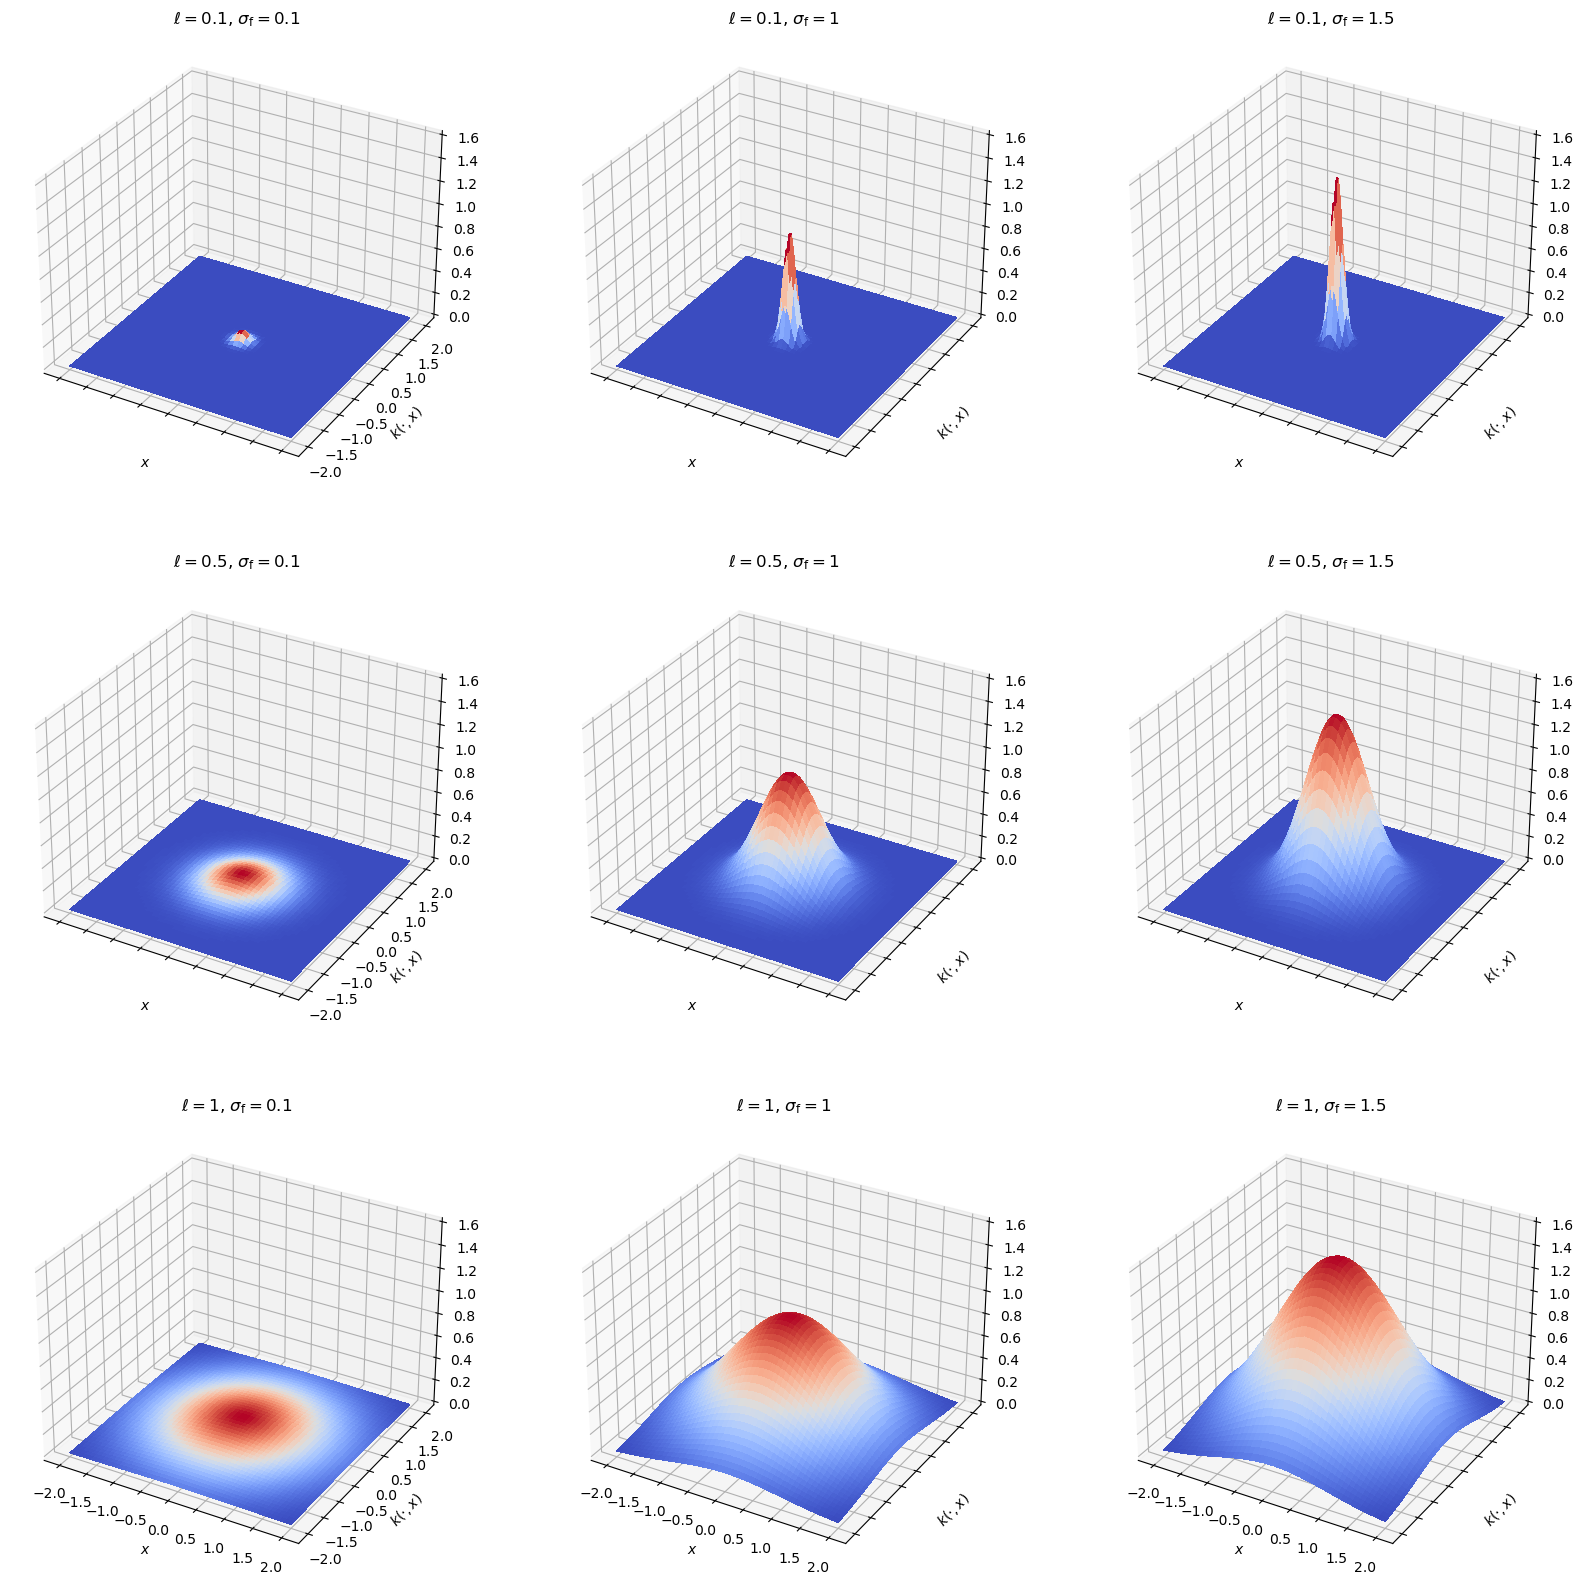

In [4]:
### BEGIN SOLUTION
# Helpful for 3D plots
from matplotlib import cm

X = np.linspace(-2, 2, 100)
Y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)

Z = psi_se(R, ell=0.5, sigma_f=1)

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig, axs = plt.subplots(3, 3, 
                        sharex=True, 
                        sharey=True, 
                        figsize=(20,20),
                        subplot_kw={"projection": "3d"})

for i_ell, ell in enumerate(ells):
    for i_sigma, sigma_f in enumerate(sigmas):
        Z = psi_se(R, ell=ell, sigma_f=sigma_f)
        ax = axs[i_ell,i_sigma]
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        
        ax.set_zlim([0, 1.6])
        ax.set_xlabel('$x$')
        ax.set_ylabel('$k(\cdot,x)$')
        ax.set_title(f'$\ell={ell}$, $\sigma_\mathrm{{f}}={sigma_f}$')
        
### END SOLUTION

**Question** In the following, we will plot repeatedly sample paths of GPs of different covariance functions. Implement a convenience function, that can plot GP sample paths. You can use for example the `scikit-learn` library.

In [5]:
### BEGIN SOLUTION
# We will use sklearn from now on
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, ConstantKernel, 
                        Matern, RationalQuadratic, ExpSineSquared, DotProduct)

def plot_gp_samples(gpr_model, n_samples, ax):
    """Samples and plots sample paths from a given GP
    
    Given a scikit-learn GaussianProcessRegressor model, this function draws a specified number
    of sample paths from the GP model and plots them on a specified matplotlib Axes object.
    
    See also
    https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py
    
    Args:
        gpr_model: A GaussianProcessRegressor model from which to draw GP samples
        n_samples: A positive integer, the number of samples to draw and plot
        ax: A matplotlib Axes object, where to plot
    """
    xs = np.linspace(0,4,1000)
    X = xs.reshape([-1,1])
    
    ys_mean, ys_std = gpr_model.predict(X, return_std=True)
    ys_samples = gpr_model.sample_y(X, n_samples)
    
    lw_sample_path = 1.5
    color_sample_path = 'blue'
    alpha_sample_path = 0.4
    for i in range(n_samples):
        ax.plot(xs, ys_samples[:,i],
                lw=lw_sample_path,
                color='blue',
                alpha=0.4)
    
    ax.plot(xs, ys_mean,
            lw=2,
            color='gray',
            label='Mean')
    
    ax.fill_between(xs,
                    ys_mean - ys_std,
                    ys_mean + ys_std,
                    color='lightblue',
                    alpha = 0.4,
                    label='Mean $\pm$ 1 SD')
    
    handles, labels = ax.get_legend_handles_labels()
    patch = matplotlib.lines.Line2D([], [], 
                                    color=color_sample_path, 
                                    linewidth=lw_sample_path, 
                                    alpha=alpha_sample_path,
                                    label='Sample path')
    handles.append(patch)
    
    ax.set_xlabel('$x$')
    ax.legend(handles=handles)
### END SOLUTION

**Question** Use the function from the previous question to plot several sample paths of a GP with zero mean and the SE covariance function with different hyperparameters. Interpret the role of the hyperparameters on the behavior of the sample paths. Can you explain the behavior from the formula of the SE covariance function?

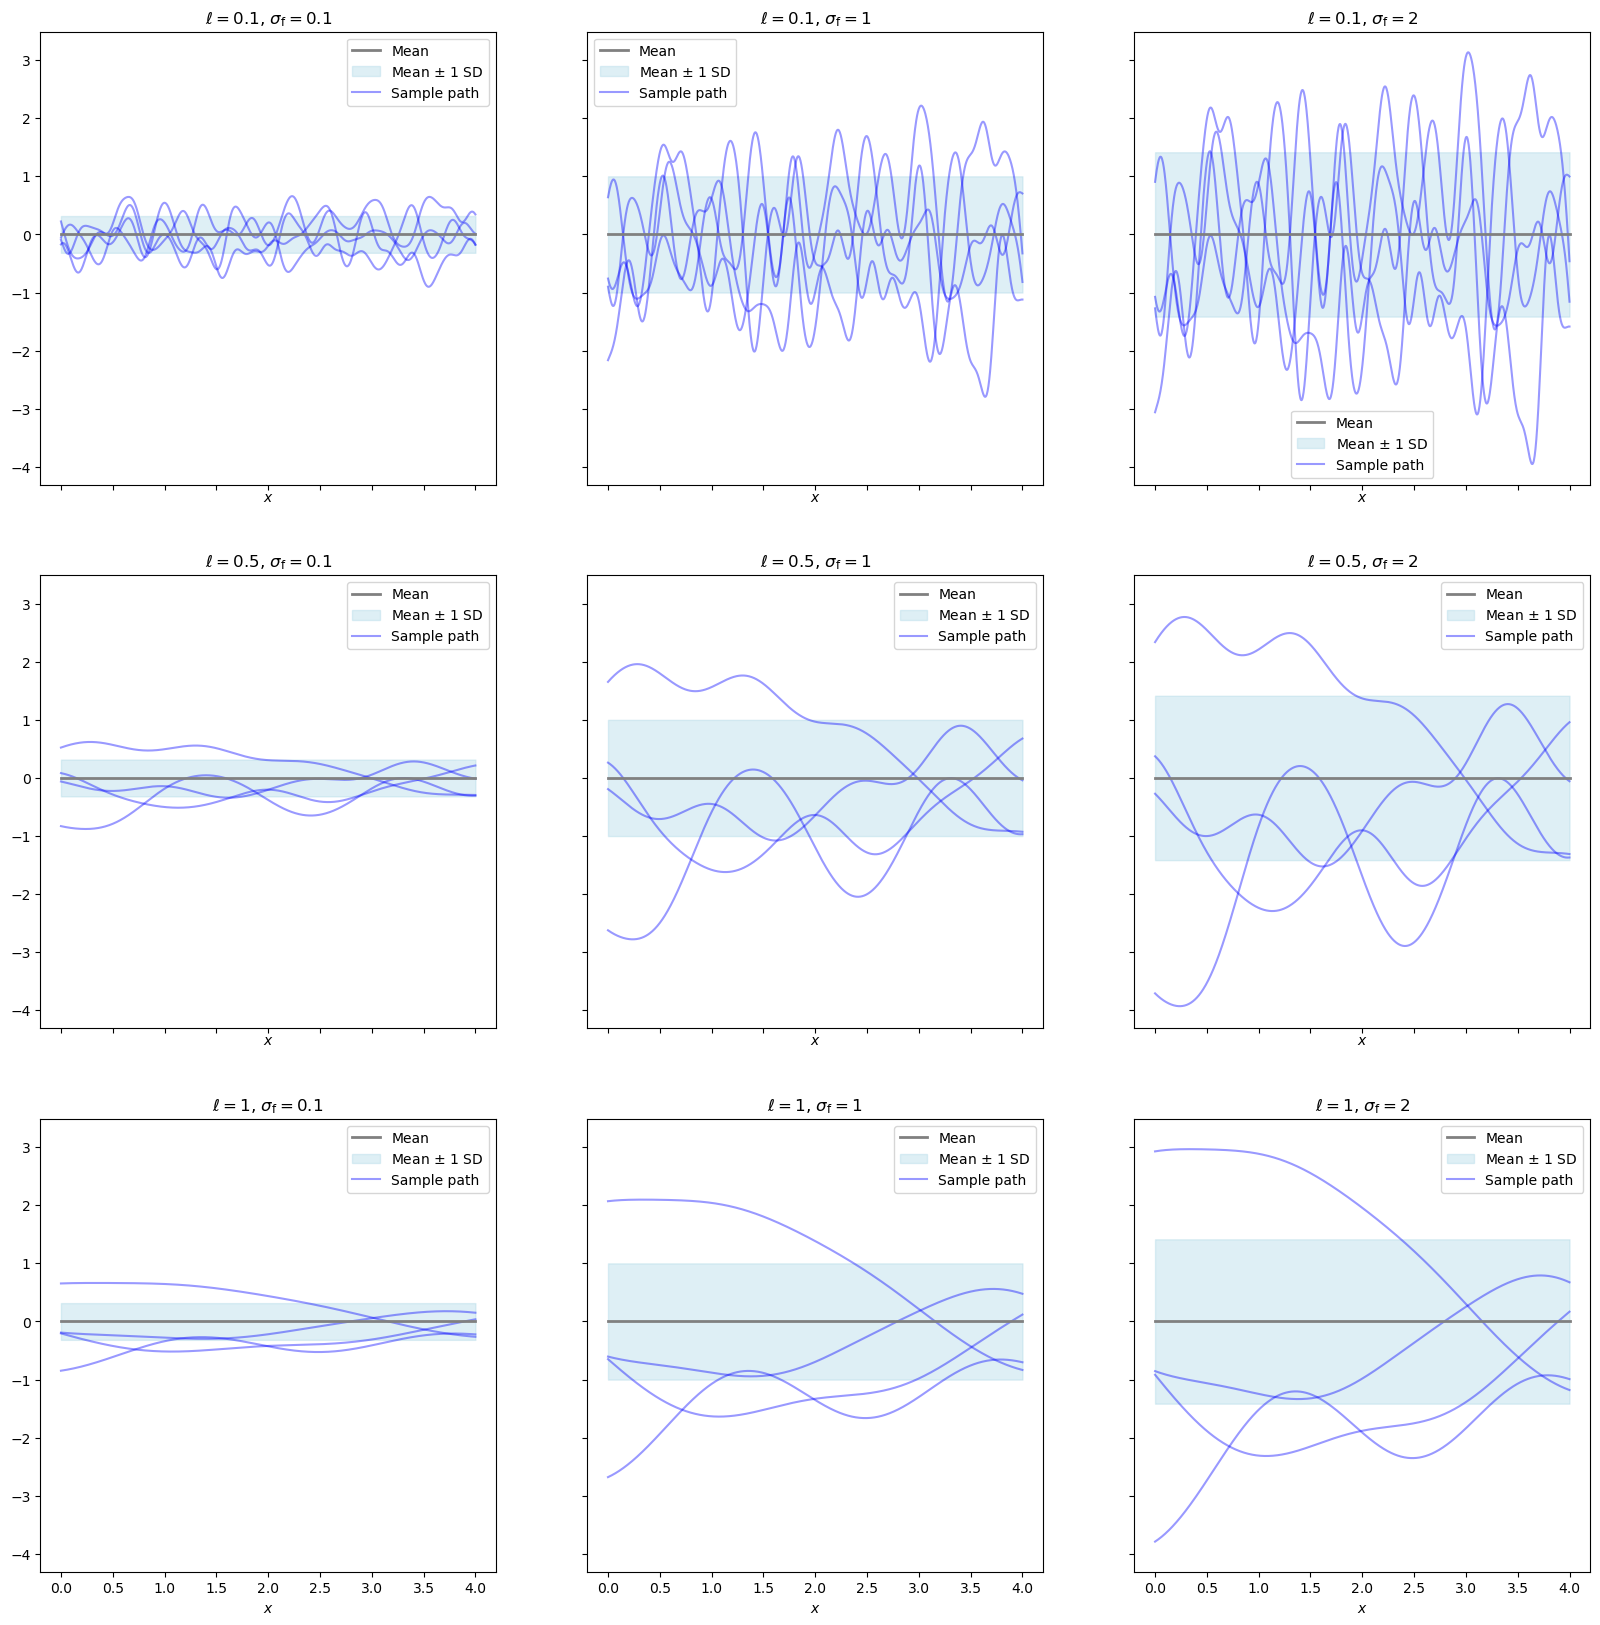

In [6]:
### BEGIN SOLUTION
ells = [0.1, 0.5, 1]
sigmas = [0.1, 1, 2]
fig, axs = plt.subplots(3,3, figsize=(20,20), sharex=True, sharey=True)
for i_ell, ell in enumerate(ells):
    for i_sigma, sigma_f in enumerate(sigmas):
        se_kernel = sigma_f*RBF(length_scale=ell, length_scale_bounds="fixed")
        gpr_model = GaussianProcessRegressor(kernel=se_kernel)
        plot_gp_samples(gpr_model, 4, axs[i_ell,i_sigma])
        axs[i_ell,i_sigma].set_title(f'$\ell={ell}$, $\sigma_\mathrm{{f}}={sigma_f}$')
### END SOLUTION

### The Matern covariance function
The Matern covariance function is defined by
$$
\Psi_\mathrm{Matern}(r) = \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \frac{\sqrt{2\nu}r}{\ell} \right)^\nu K_\nu\left( \frac{\sqrt{2\nu}r}{\ell} \right)
$$
with hyperparameters $\nu,\ell\in\mathbb{R}_{>0}$. Note that it would be possible to also multiply it with a signal variance parameter $\sigma_\mathrm{f}$, however, since its influence is the same for all translation invariant covariance functions, we leave it out from now on.

$\Gamma$ is the Gamma function and $K_\nu$ is a modified Bessel function.

If $\nu=p+\frac 1 2$ for some $p\in\mathbb{N}$, then the expression for the Matern kernel simplified, cf. (4.16) and (4.17) in [RW06]. In particular, for $\nu=1/2$ we get
$$
\Psi_\mathrm{Matern}(r) = \exp\left(-\frac{r}{\ell} \right),
$$
which is also called the exponential kernel.

The most common cases in machine learning are $\nu=3/2$ and $\nu=5/2$ (often called Matern-3/2 and Matern-5/2).

**Question** Implement $\Psi_\mathrm{Matern}$ as a numpy function and plot $k_\mathrm{Matern}(\cdot,0)$ ($D=1$) for $\nu=1/2, 3/2, 5/2$ and $\ell=0.1, 0.5, 1$. How do the two hyperparameter influence the shape of the function? 

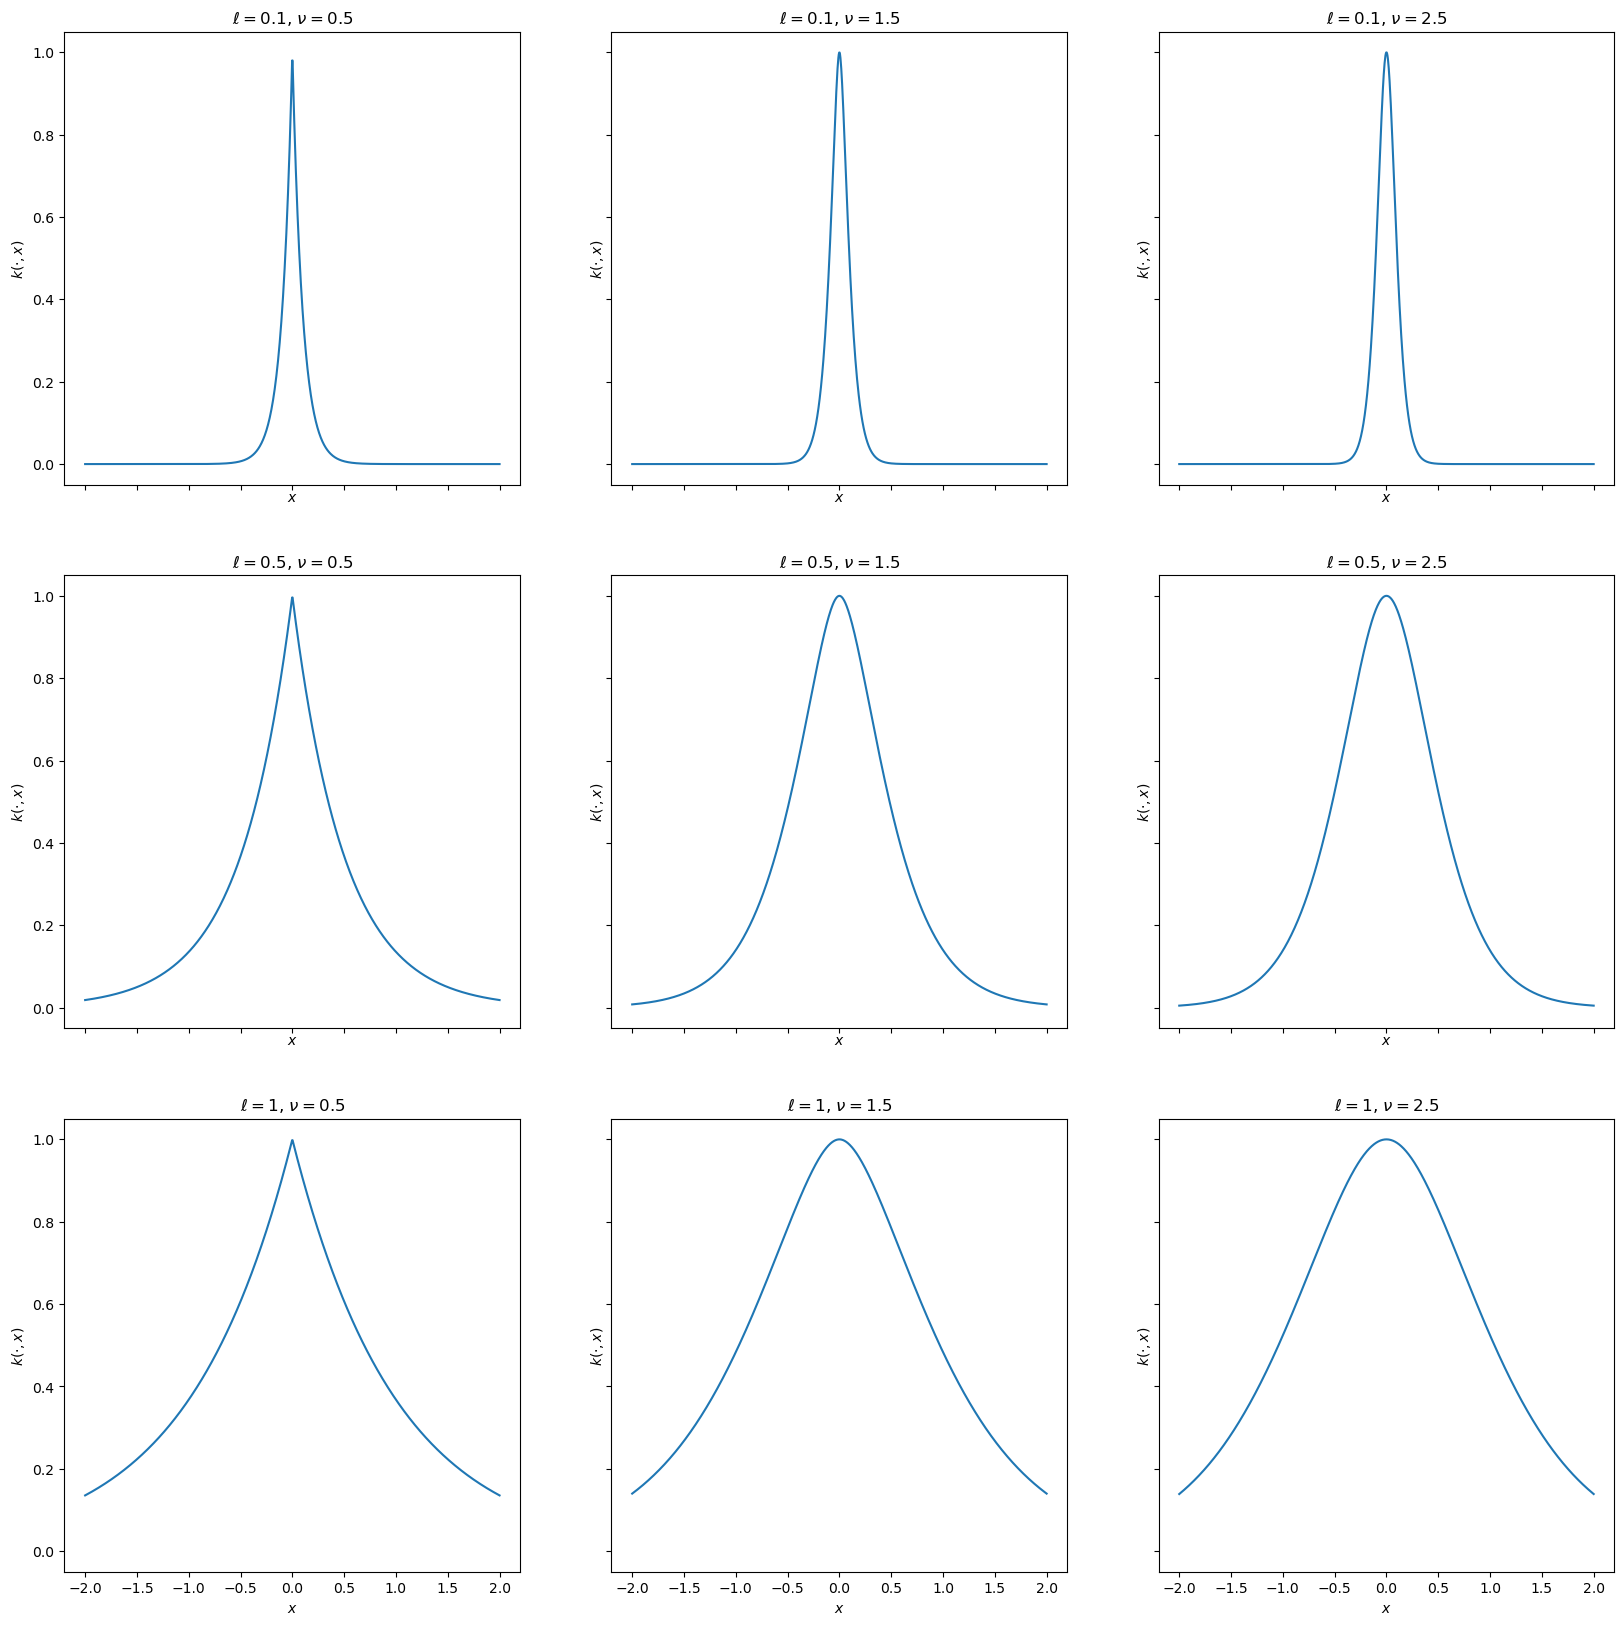

In [7]:
### BEGIN SOLUTION
from scipy.special import kv, gamma

def psi_matern(r, ell, nu):
    s = r*np.sqrt(2*nu)/ell
    c = 2**(1-nu)/gamma(nu)
    return c*(s**nu)*kv(nu, s)

# Hyperparameters
ells = [0.1, 0.5, 1]
nus = [0.5, 1.5, 2.5]

# Plotting grid
xs = np.linspace(-2,2,1000)

# Since the covariance function is translation invariant, the choice of x does not matter and we set x=0
fig, axs = plt.subplots(3,3, figsize=(20,20), sharex=True, sharey=True)
for i_ell, ell in enumerate(ells):
    for i_nu, nu in enumerate(nus):
        ys = psi_matern(np.abs(xs), ell=ell, nu=nu)
        ax = axs[i_ell,i_nu]
        ax.plot(xs, ys)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$k(\cdot,x)$')
        ax.set_title(f'$\\ell={ell}$, $\\nu={nu}$')
        
### END SOLUTION

**Question** Plot the Matern covariance function for $\ell=1$ and increasing $\nu$ together with the squared exponential covariance function for $\sigma_\mathrm{f}=1$ and $\ell=1$. What do you observe?

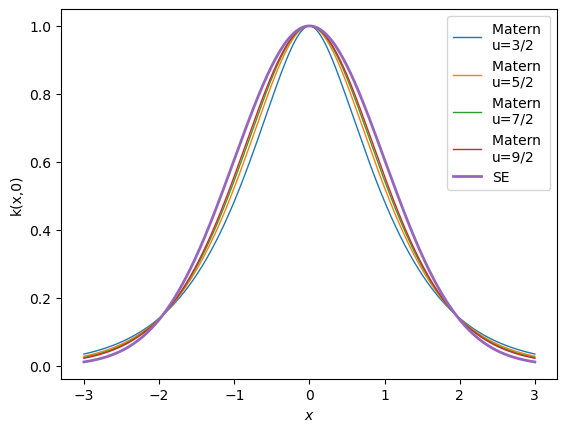

In [8]:
### BEGIN SOLUTION
nus = 0.5 + np.arange(1, 5)
xs = np.linspace(-3,3,1000)

for nu in nus:
    plt.plot(xs, psi_matern(np.abs(xs), ell=1, nu=nu), lw=1, label=f'Matern \nu={int(2*nu):d}/2')
plt.plot(xs, psi_se(xs, ell=1, sigma_f=1), lw=2, label='SE')
plt.legend()
plt.xlabel('$x$')
_ = plt.ylabel('k(x,0)')
### END SOLUTION

Indeed, one can show that for $\nu\rightarrow\infty$ the Matern covariance function converges to the SE covariance function.

**Question** Plot several sample paths of a GP with zero mean and the Matern covariance function with different hyperparameters. Interpret the role of the hyperparameters on the behavior of the sample paths.

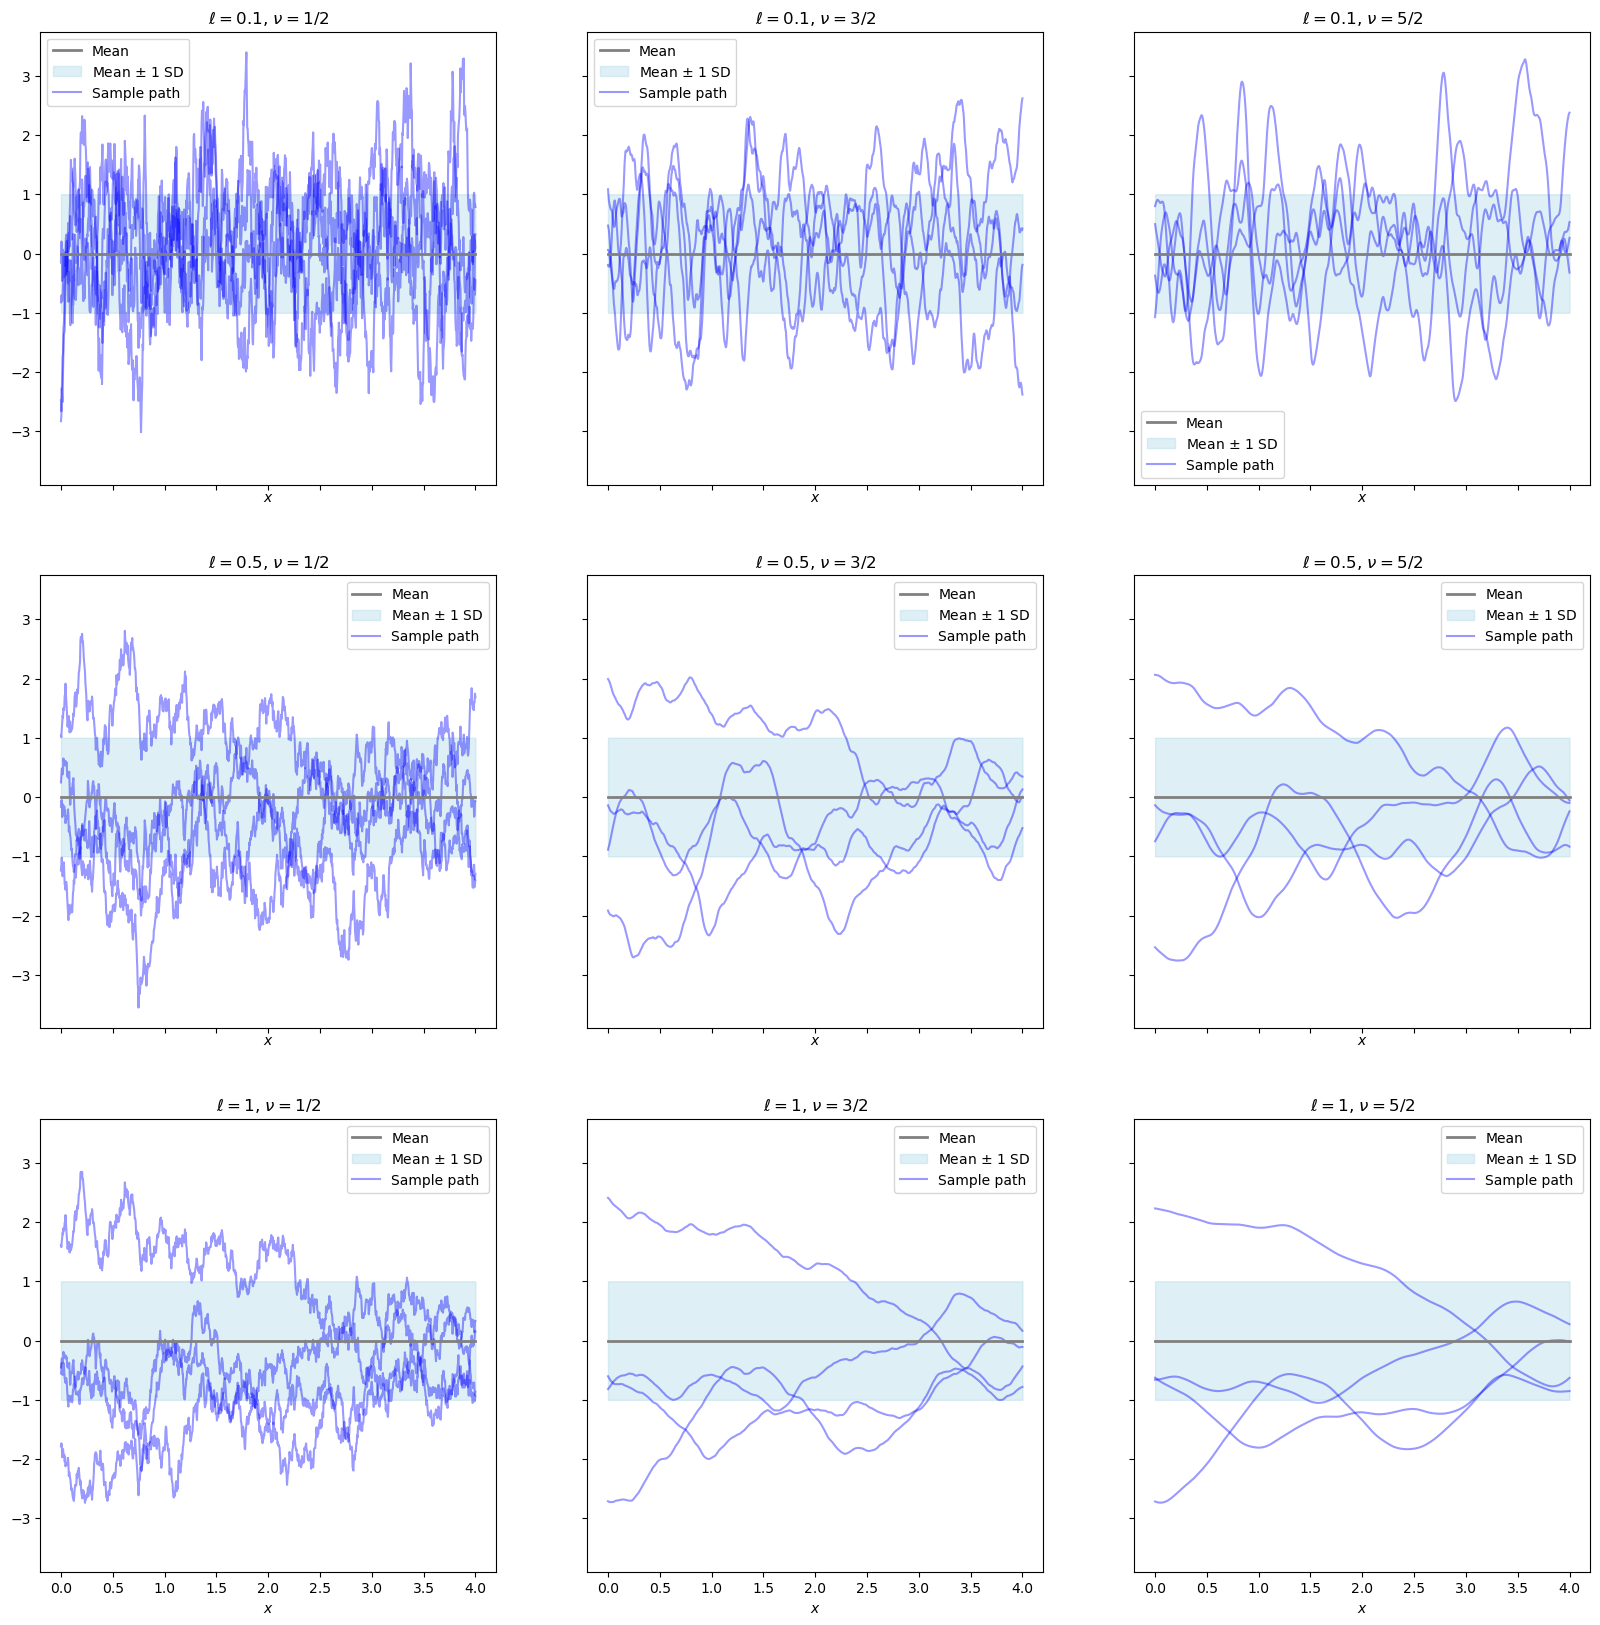

In [9]:
### BEGIN SOLUTION
ells = [0.1, 0.5, 1]
nus = [0.5, 1.5, 2.5]
fig, axs = plt.subplots(3,3, figsize=(20,20), sharex=True, sharey=True)
for i_ell, ell in enumerate(ells):
    for i_nu, nu in enumerate(nus):
        matern_kernel = Matern(length_scale=ell, nu=nu, length_scale_bounds="fixed")
        gpr_model = GaussianProcessRegressor(kernel=matern_kernel)
        plot_gp_samples(gpr_model, 4, axs[i_ell,i_nu])
        axs[i_ell,i_nu].set_title(f'$\\ell={ell}$, $\\nu={int(2*nu):d}/2$')
### END SOLUTION

### Periodic kernel
We now come to the periodic kernel, sometimes call ExpSineSquared kernel, given by
$$
\Psi_\mathrm{per}=\exp\left( - \frac{2\sin^2\left( \pi r/p \right)}{\ell^2} \right)
$$
with hyperparameters $\ell, p>0$.

**Question** Plot $k_\mathrm{per}$ for different hyperparameters in 1D. Interpret the role of the hyperparameters. Can you infer their influence from the formula of the periodic covariance function?

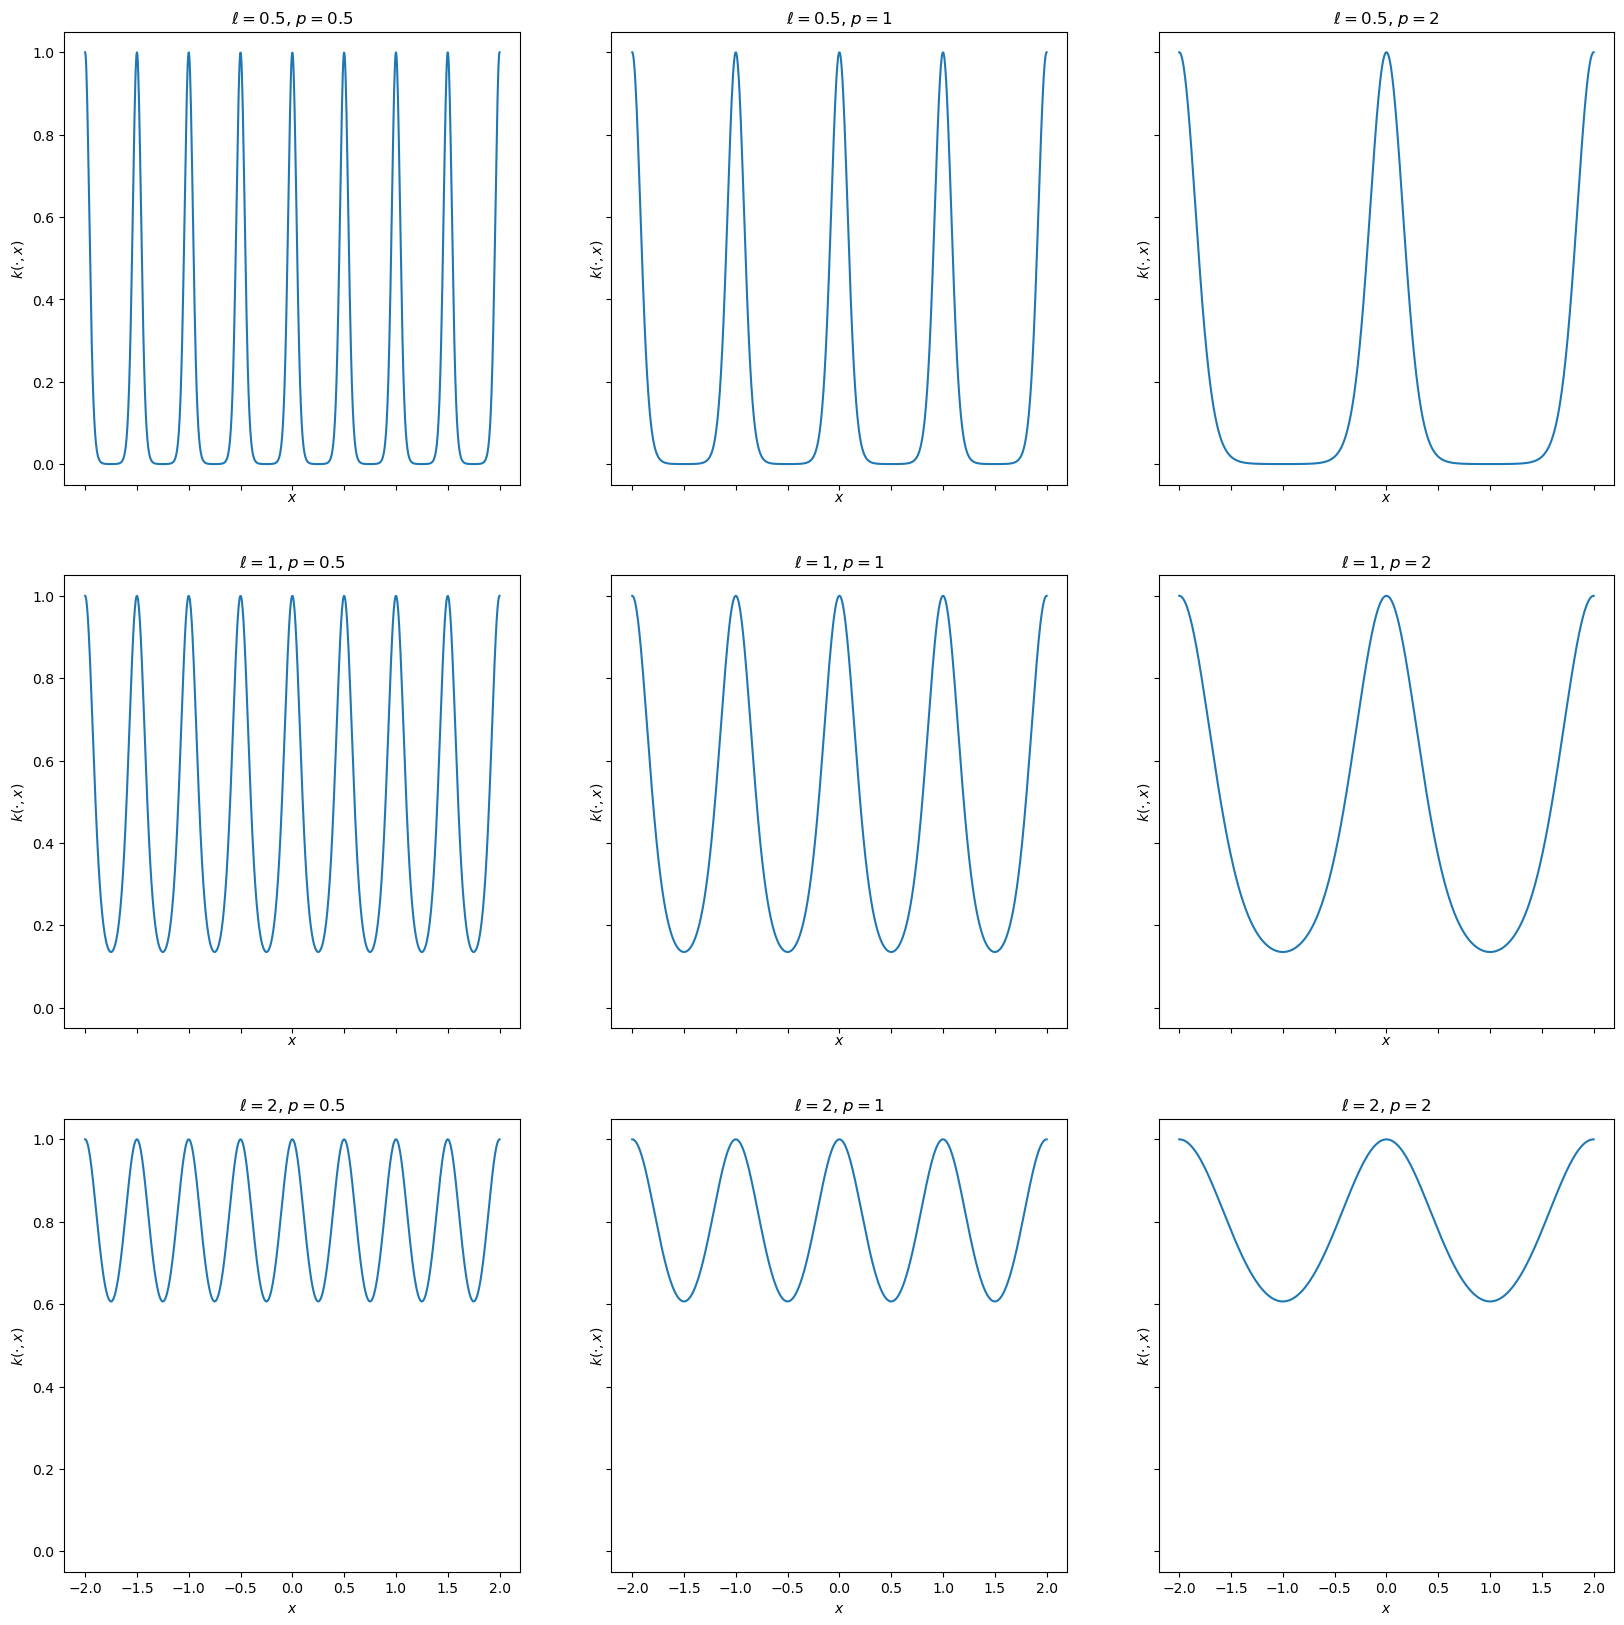

In [10]:
### BEGIN SOLUTION
def psi_per(r, ell, p):
    return np.exp(
        -2*np.sin(
            np.pi*r/p)**2/(ell**2)
    )

# Hyperparameters
ells = [0.5, 1, 2]
ps = [0.5, 1, 2]

# Plotting grid
xs = np.linspace(-2,2,1000)

# Since the covariance function is translation invariant, the choice of x does not matter and we set x=0
fig, axs = plt.subplots(3,3, figsize=(20,20), sharex=True, sharey=True)
for i_ell, ell in enumerate(ells):
    for i_p, p in enumerate(ps):
        ys = psi_per(np.abs(xs), ell=ell, p=p)
        ax = axs[i_ell,i_p]
        ax.plot(xs, ys)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$k(\cdot,x)$')
        ax.set_title(f'$\ell={ell}$, $p={p}$')
### END SOLUTION

**Question** Plot some sample paths from a GP prior with periodic covariance function with different hyperparameters. Interpret the influence of the hyperparameters on the sample paths.

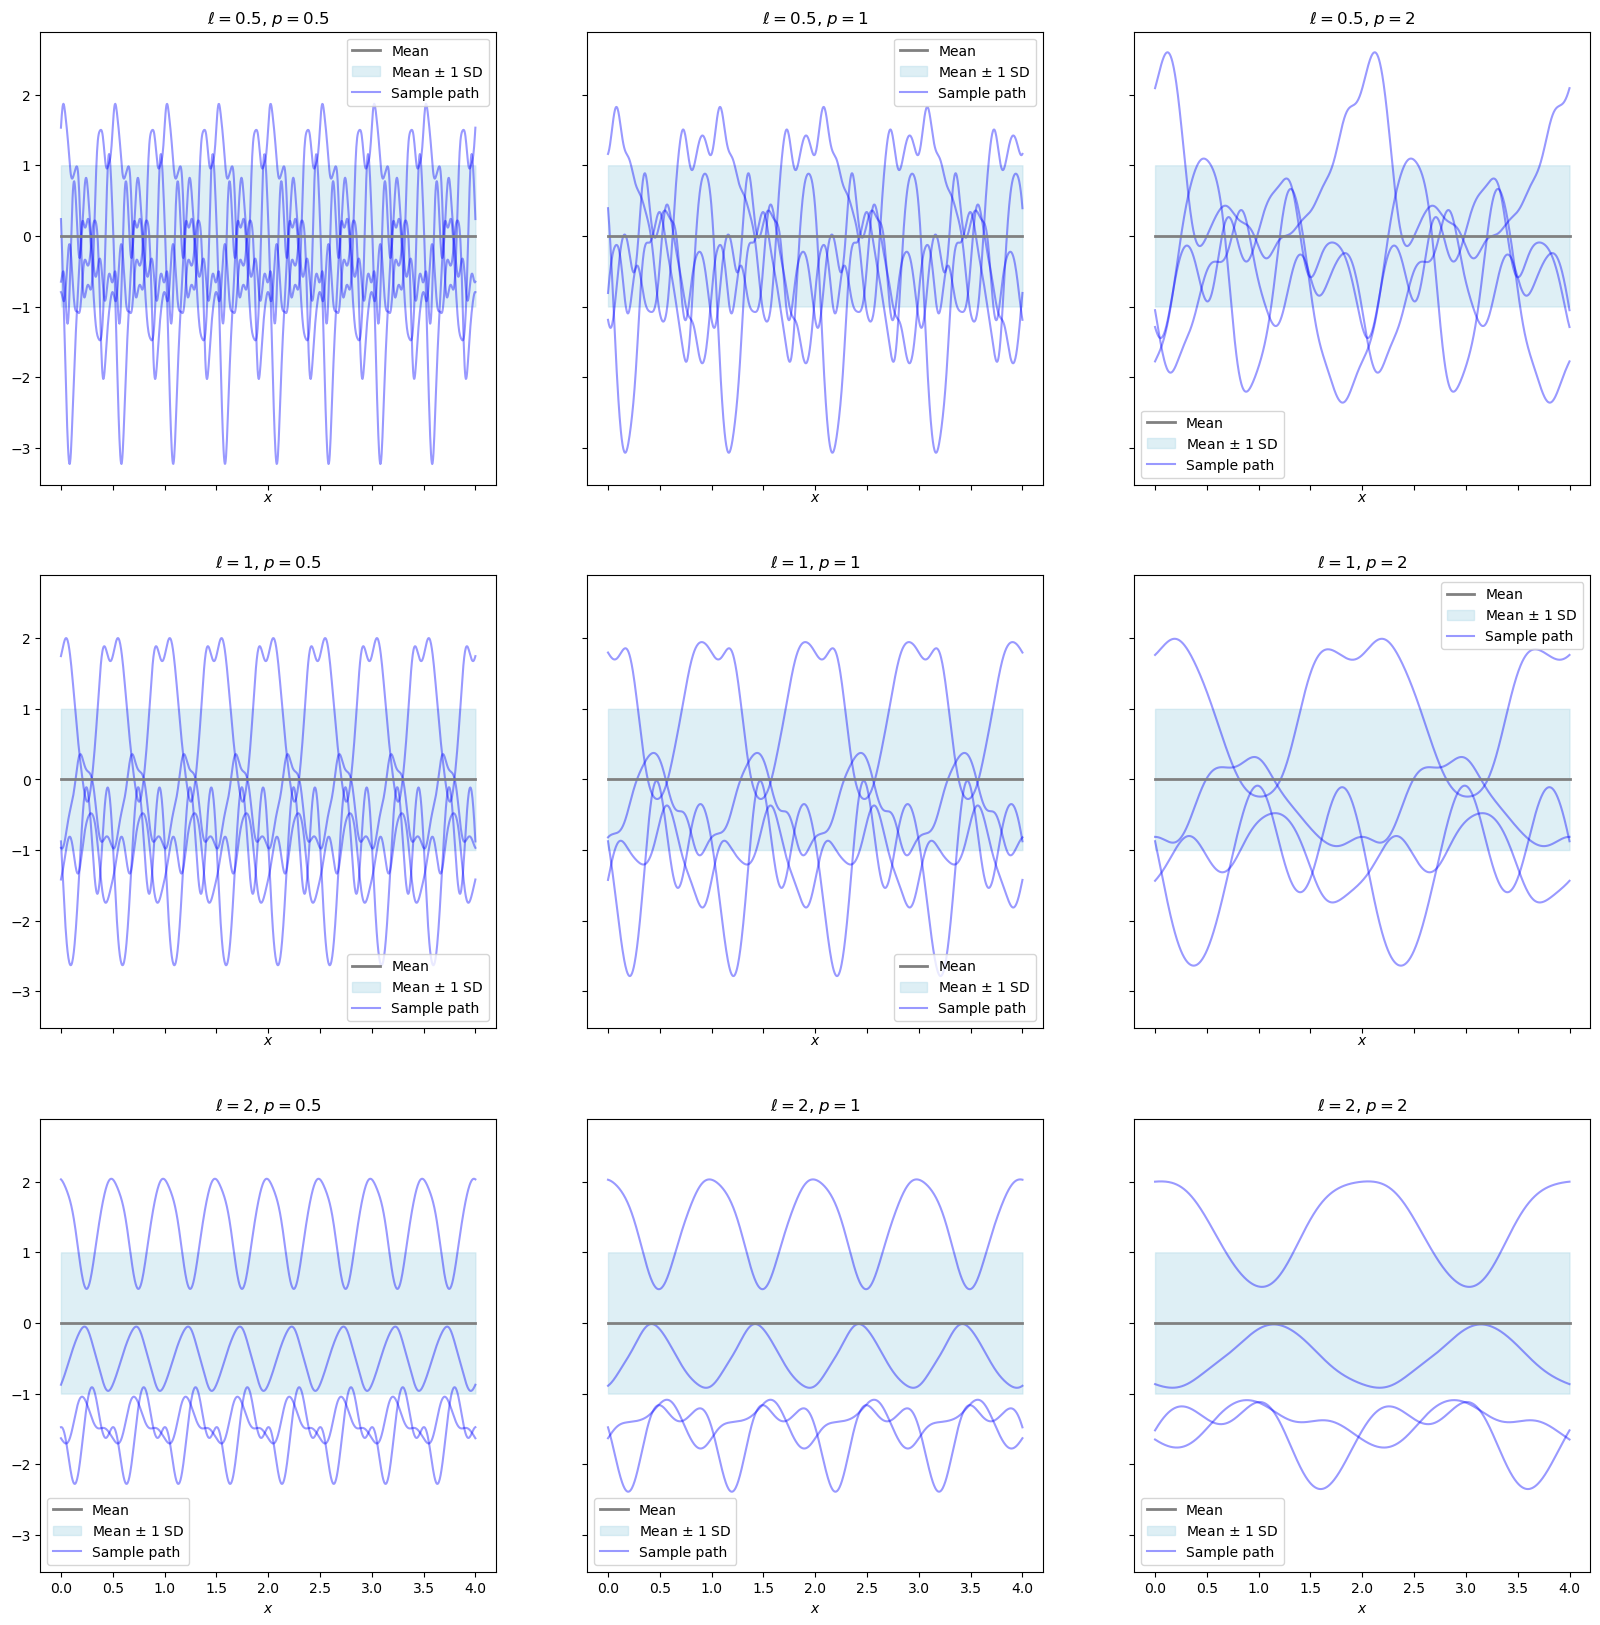

In [11]:
### BEGIN SOLUTION
# Hyperparameters
ells = [0.5, 1, 2]
ps = [0.5, 1, 2]

fig, axs = plt.subplots(3,3, figsize=(20,20), sharex=True, sharey=True)
for i_ell, ell in enumerate(ells):
    for i_p, p in enumerate(ps):
        per_kernel = ExpSineSquared(length_scale=ell, length_scale_bounds="fixed", 
                         periodicity=p, periodicity_bounds="fixed")
        gpr_model = GaussianProcessRegressor(kernel=per_kernel)
        plot_gp_samples(gpr_model, 4, axs[i_ell,i_p])
        axs[i_ell,i_p].set_title(f'$\ell={ell}$, $p={p}$')
### END SOLUTION

**Question** Condition a GP prior with SE kernel and a GP prior with the periodic kernel (with parameter $p=2$), both with $\ell=0.5$, on the data set $(1, 0.5)$, assuming no noise. Plot the posterior mean, SD and some sample paths. What do you observe? Interpret the different outcomes.

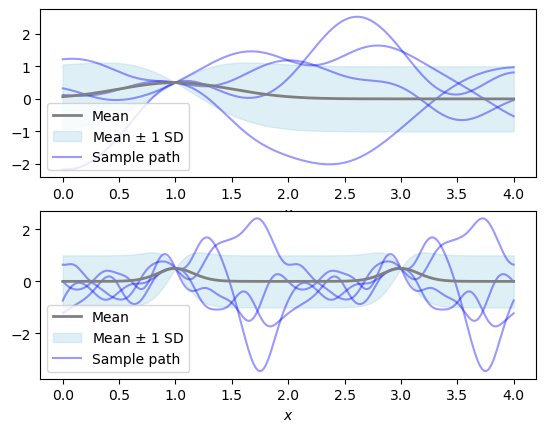

In [12]:
### BEGIN SOLUTION
X = np.array([[1]])
y = np.array([0.5])
se_kernel = ConstantKernel(constant_value=1, constant_value_bounds="fixed")*RBF(
    length_scale=0.5, length_scale_bounds="fixed")
per_kernel = ConstantKernel(constant_value=1, constant_value_bounds="fixed")*ExpSineSquared(
     length_scale=0.5, length_scale_bounds="fixed", periodicity=2, periodicity_bounds="fixed")
gpr_se = GaussianProcessRegressor(kernel=se_kernel).fit(X,y)
gpr_per = GaussianProcessRegressor(kernel=per_kernel).fit(X,y)

fig, axs = plt.subplots(2,1)
plot_gp_samples(gpr_se, 4, axs[0])
plot_gp_samples(gpr_per, 4, axs[1])
### END SOLUTION

# Nonstationary covariance functions


The dot-product covariance function is given by
$$
k_\mathrm{dot}(x,x')=\Phi(\langle x, x'\rangle)
$$
for an appropriate function $\Phi$. For simplicity we consider only
$$
k_\mathrm{dot}(x,x')=\langle x, x'\rangle + b
$$
for some $b\geq 0$.

**Question** Plot some sample paths from the dot product covariance function with $b=0$. What do you observe? How can this be interpreted?

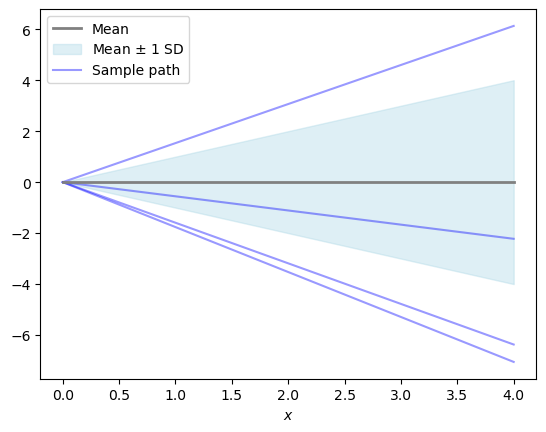

In [13]:
kernel_dot = DotProduct(sigma_0=0)
gpr_dot = GaussianProcessRegressor(kernel=kernel_dot)
fig = plt.figure()
plot_gp_samples(gpr_dot, 4, plt.gca())

**References**
[RW06] Rasmussen, Williams, Gaussian Processes for Machine Learning, MIT Press 2006
(available online at https://gaussianprocess.org/gpml/)